# Convert curve image to timestamp-points
This test aims to convert curve images into timestamped points, it may helpping in data analysis during its early stages when the data source is not yet ready.

<p align="center">
<img src=https://github.com/Plus-1000/Convert-curve-image-to-timestamp-points/blob/main/image/get%20ready%20pic.jpg width="600" >
<b>

-## mark down

In [11]:
'''
Try converting a freehand sketch or a screen-captured curve to timestamped points
This can be helpful for initial studies when the sensor is not yet ready
Wang Jian 2024 June 
'''
import pandas as pd
import scipy
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.util import invert
from IPython.display import display, clear_output
import random
from scipy import interpolate
import sys
import os
scipy.__version__
# print(os.getcwd())

'1.11.1'

### **Step 1: Prepare the curve image**
The image can be a photo of a hand-drawn curve or one captured from a webpage. If necessary, adjust the brightness and contrast using FastStone or other apps. If you're proficient with Pillow, you can automate these adjustments using your own formula. 

In [12]:
# =============curve recognization===========
def img_recg(image_file):
    # ==============recognize curves=============
    max_points=1000 # by default, system will generate ~5000 points

    threshold=128  
    image = Image.open(image_file)  # Load the image
    gray_image = image.convert('L')  # Convert to grayscale

    # Apply binary threshold
    binary_image = gray_image.point(lambda p: p > threshold and 255)

    # Convert binary image to numpy array
    binary_array = np.array(binary_image)

    # Invert binary array (PIL uses 255 for white and 0 for black, we need 1 for white and 0 for black)
    binary_array = np.where(binary_array == 255, 0, 1)

    # create thin line 
    thinned_array = skeletonize(binary_array) 

    # Get coordinates of non-zero points (the thinned curve)
    curve_coordinates = np.column_stack(np.where(thinned_array == 1))

    #===============image width and height===================
    width, height = image.size
    # print(width, height)
    global plot_ratio
    plot_ratio=height/width
    
    # #==============limit number of points generated================
    # if len(curve_coordinates) > max_points:
    #     # by default, system will generate ~5000 points
    #     curve_coordinates = random.sample(list(curve_coordinates), max_points)

    #===============write pts coordinate to dataframe=============
    coordinates=curve_coordinates
    list_x=[]
    list_y=[]
    for point in coordinates:
        list_x.append(point[1])
        list_y.append(-point[0])

    dict = {'X': list_x, 'Y': list_y} 
    df = pd.DataFrame(dict) 
    df=df.sort_values(by='X', ascending=True) # It may cause problems when recg non chronological curve 
    # print('check x column:  ', df['X'].unique())
    df.to_csv(path+'01_after_recog.csv', index=False)
    df.reset_index(drop=True, inplace=True) # remove index before pass it to next function
    return df, image

In [13]:
#===========remove point comes with same X coordinate value=============
def del_extra(df):
    # print(df)
    list_x=[]
    list_y=[]
    for i in range(0,len(df)-1,1): 
            next_x=df['X'][i+1]
            # print(last_x, current_x, next_x)
            # df['X'][i]!=df['X'][i+1]:
            if df['X'][i]!=next_x:
                list_x.append(df['X'][i])
                list_y.append(df['Y'][i])
                # print('append')

    dict = {'X': list_x, 'Y': list_y} 
    df = pd.DataFrame(dict) 
    # print('check x column:  ', df['X'].unique())
    df.to_csv(path+'02_after_del_extra.csv', index=False)

    return df
    

In [14]:
#===========remove point comes with same X coordinate value=============
def del_extra(df):
    # print(df)
    list_x=[]
    list_y=[]
    for i in range(0,len(df)-1,1): 
            next_x=df['X'][i+1]
            # print(last_x, current_x, next_x)
            # df['X'][i]!=df['X'][i+1]:
            if df['X'][i]!=next_x:
                list_x.append(df['X'][i])
                list_y.append(df['Y'][i])
                # print('append')

    dict = {'X': list_x, 'Y': list_y} 
    df = pd.DataFrame(dict) 
    # print('check x column:  ', df['X'].unique())
    df.to_csv(path+'02_after_del_extra.csv', index=False)

    return df

In [15]:

    
# ===================2d point interpolation===========================
def interp(df,x_step):
    steps=x_step+1
    x_array = df['X'].to_numpy()
    y_array = df['Y'].to_numpy() # x,y to array

    x_new = np.linspace(x_array.min(), x_array.max(), steps) # new X coordinate value 

    # for n in ['linear','zero', 'slinear', 'quadratic', 'cubic', 4, 5]
    f= interpolate.interp1d(x_array, y_array,kind="cubic") # fomula f(x)
    y_new=f(x_new) # get new point set
    # print('type y_new=================:    ',type(y_new))
    dict = {'X': x_new.tolist(), 'Y': y_new.tolist()} 
    df = pd.DataFrame(dict) 
    df.to_csv(path+'03_after_interp.csv', index=False)
    return df






In [16]:



# =================scale x, y axis===================
def scale(df,x_start,x_end, y_start,y_end):
    x_new=df['X'].to_numpy()
    y_new=df['Y'].to_numpy()
    
    # =====scale Y array and collected by a list=====
    new_list_y=[]
    for i in y_new: 
        ratio = (i - y_new.min()) / (y_new.max() - y_new.min())
        X_scaled = ratio * (y_end - y_start) + y_start
        new_list_y.append(X_scaled)
    y_new_scaled=np.array(new_list_y)

    # =====scale X array and collected by a list=====
    new_list_x=[]
    for i in x_new: 
        ratio = (i - x_new.min()) / (x_new.max() - x_new.min())
        X_scaled = ratio * (x_end - x_start) + x_start
        new_list_x.append(X_scaled)
    x_new_scaled=np.array(new_list_x)

    dict = {'X': new_list_x, 'Y': new_list_y} 
    df = pd.DataFrame(dict) 
    df.to_csv(path+'04_after_scale.csv', index=False)
    return df




In [17]:


# =================plot=================
def plot_all(image,df_recg,df_del_extra,df_interp,df_scale ):
    fig, axs = plt.subplots(5, 1)
    plt_width=5
    fig.set_size_inches(plt_width,int(plt_width*5*plot_ratio))
    fig.set_dpi(300)

    image_file = path+file_name
    image = Image.open(image_file)  # Load the image
    axs[0].imshow(image)
    axs[0].set_title('0: free hand curve',y=1.0, pad=-14)
    axs[0].axis('off')

    axs[1].scatter(df_recg['X'].index, df_recg['Y'],color='red', marker='.', s=0.1) 
    # axs[1].plot(df_recg['X'], df_recg['Y'],color='red', linewidth=0.5)
    axs[1].set_title('1: after recognize',y=1.0, pad=-14)

    axs[2].scatter(df_del_extra['X'], df_del_extra['Y'],color='brown',marker='o', s=0.1)
    # axs[2].plot(df_del_extra['X'], df_del_extra['Y'],color='brown', linewidth=0.5)
    axs[2].set_title('2: sorted pts',y=1.0, pad=-14)

    axs[3].scatter(df_interp['X'], df_interp['Y'],color='blue',marker='o', s=0.1)
    # axs[3].plot(df_interp['X'], df_interp['Y'],color='blue', linewidth=0.5)
    axs[3].set_title('2: after interpolation',y=1.0, pad=-14)

    df=pd.read_csv(path+'after_scale.csv', index_col=False)
    axs[4].plot(df_scale['X'], df_scale['Y'],color='green', linewidth=0.5)
    axs[4].set_title('3: after scale',y=1.0, pad=-14)

    plt.show()
    return


         
     

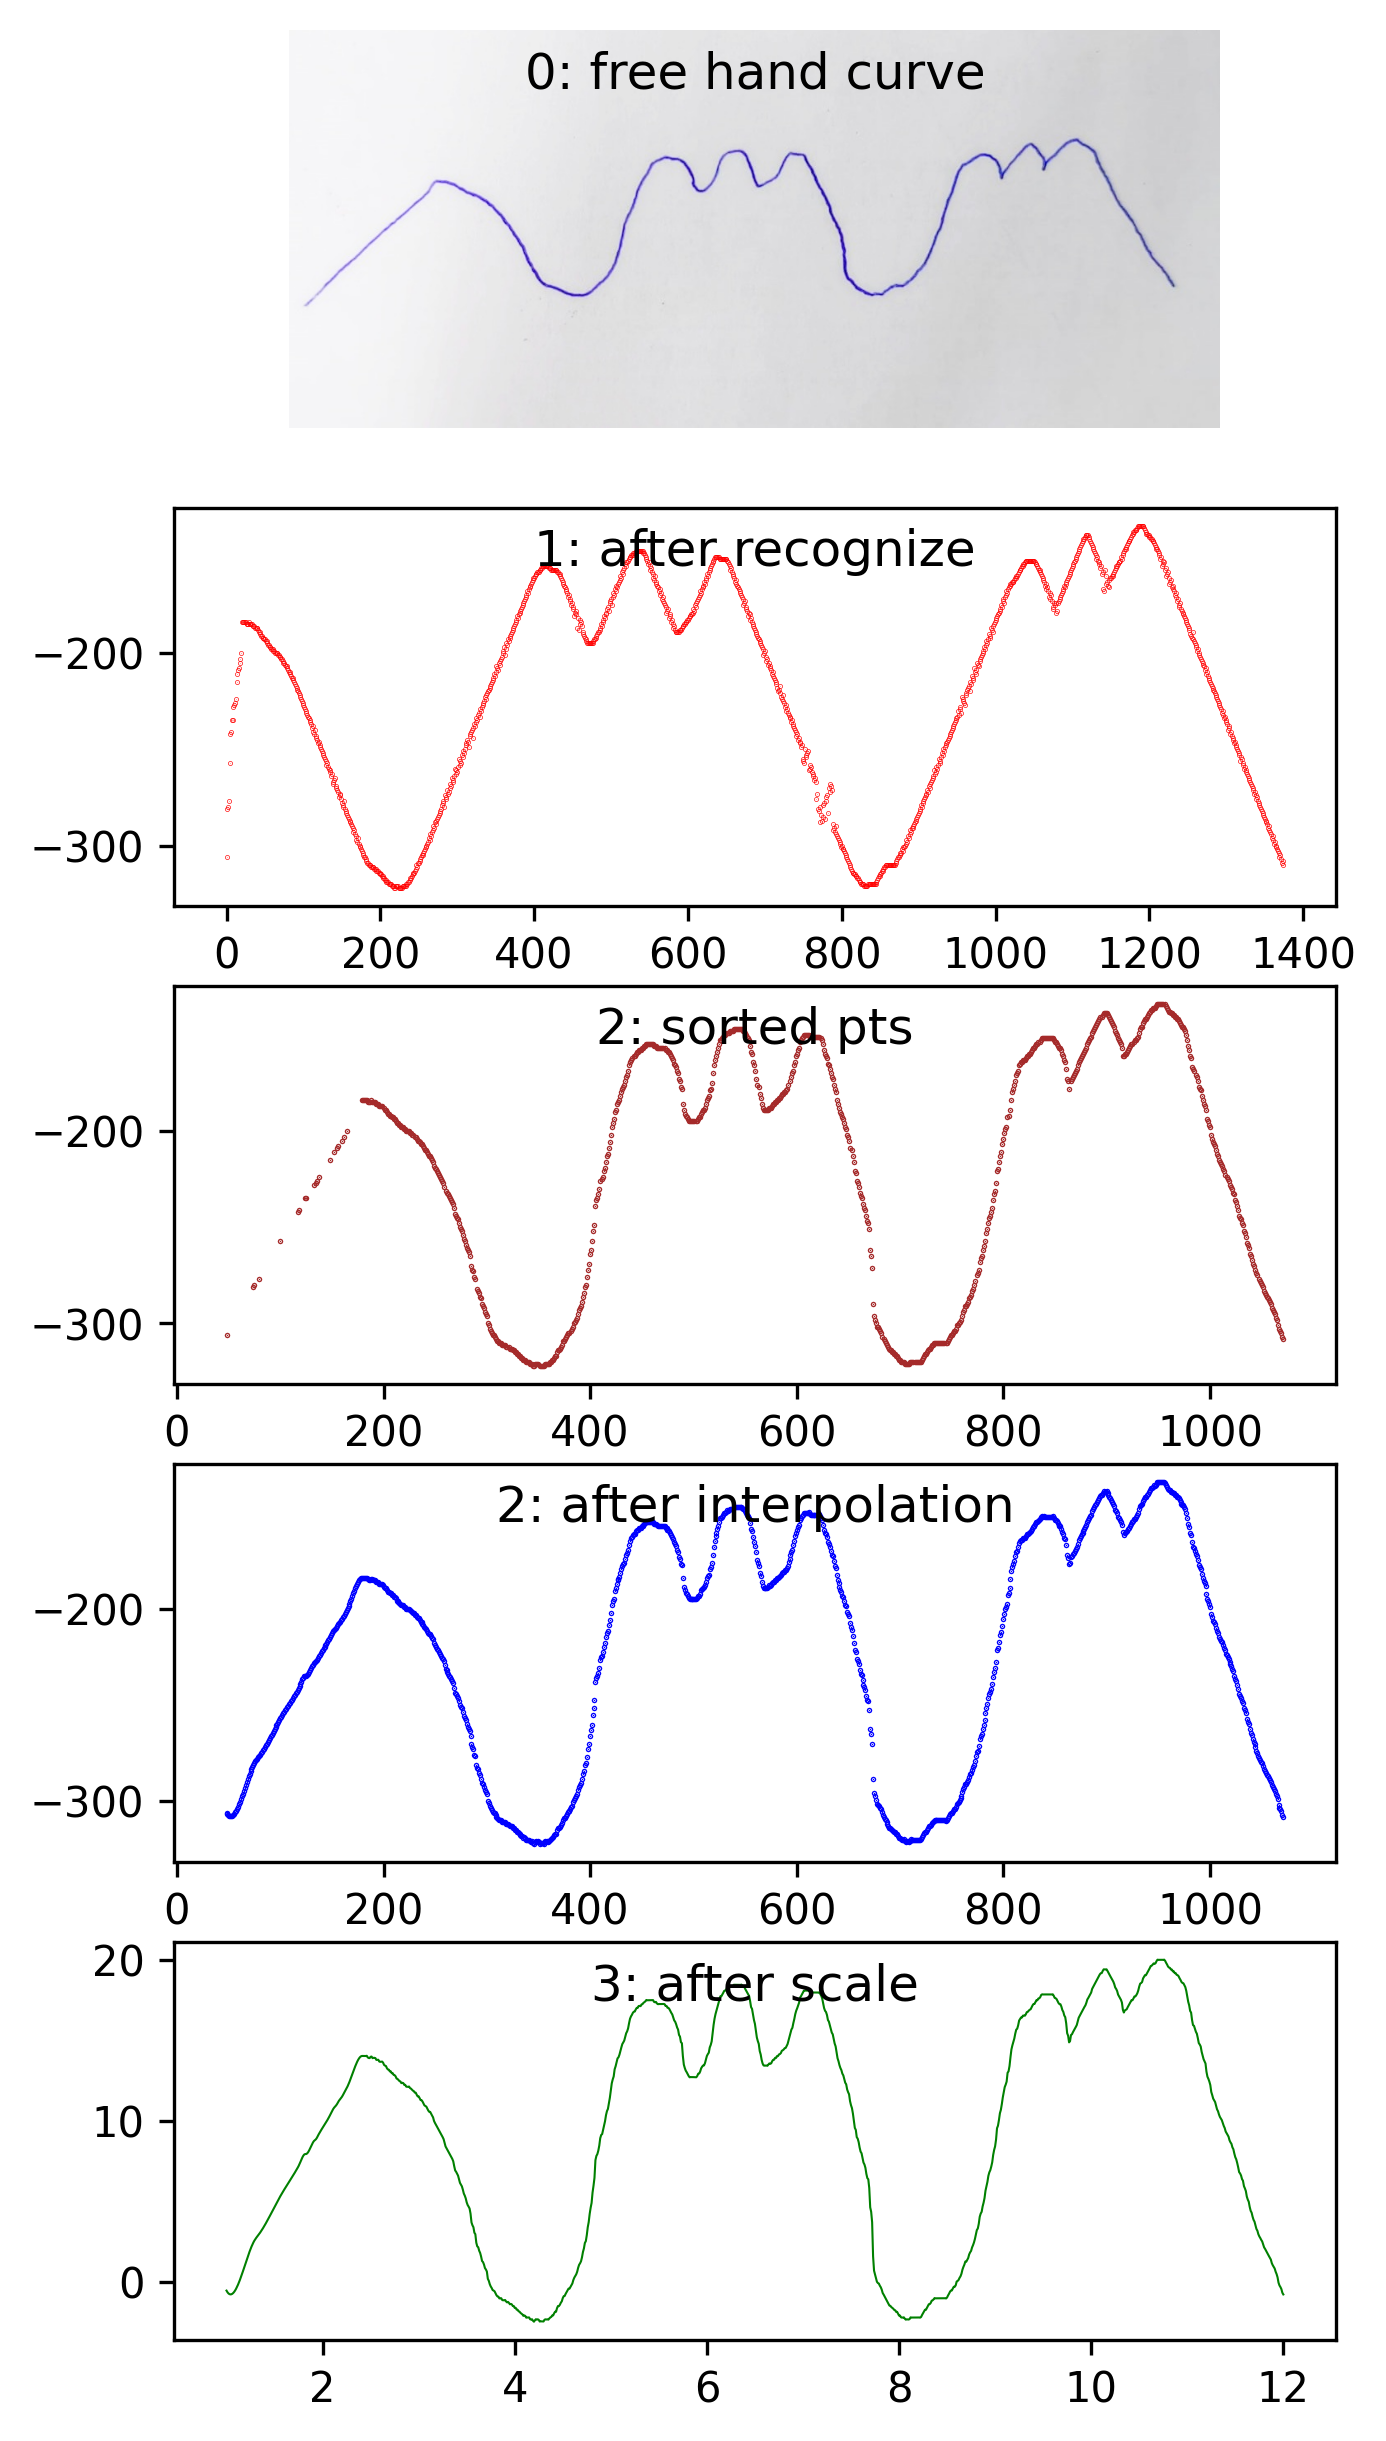

check points --> current folder --> 04_after_scale.csv


In [18]:
# ================ main ====================
global path
path=os.getcwd() + '\\'
file_name='free_hand.jpg'
image_file = path+file_name

x_start=1
x_end=12
x_step=1100 # number of points along x axis
y_start=-2.5
y_end=20
if __name__ == '__main__':
    df_recg, image=img_recg(image_file)
    df_del_extra=del_extra(df_recg)
    df_interp=interp(df_del_extra, x_step)
    df_scale=scale(df_interp,  x_start,x_end, y_start,y_end)
    # df_scale=scale(df_del_extra,  x_start,x_end,x_step, y_start,y_end)
    plot_all(image, df_recg, df_del_extra, df_interp, df_scale)
    print('check points --> current folder --> 04_after_scale.csv')